In [696]:
import subprocess
import pydot
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from scipy.stats import poisson, norm, chisquare, chi2, binom
import time
import pandas as pd
import numpy as np
import math

# Анализ графов

Код для замера времени исполнения генерации

In [29]:
def measure_execution_time(program, num_vertices, density, num_trials):
    total_time = 0
    for _ in range(num_trials):
        start_time = time.time()
        subprocess.run([program, str(num_vertices), str(density)], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end_time = time.time()
        execution_time = end_time - start_time
        total_time += execution_time
        # print(execution_time)
    average_time = total_time / num_trials
    return average_time

# g++ -std=c++17 -O3 -march=native -I./ -I./randomizer -I./common -I/prufer_graph -I/randomizer -o a main_prufer.cpp
# перед тестированием удалить из программы запись в файл
# subprocess.run(["g++", "-std=c++17", "-O3", "-march=native", "-o", "a", "prufer_prod.cpp"], check=True)
program_name = "a.exe"
num_vertices = 10000
density = 0.1  # плотность 0.1
num_trials = 10
average_execution_time = measure_execution_time(program_name, num_vertices, density, num_trials)
print(f"Average execution time over {num_trials} trials: {average_execution_time:.6f} seconds")

Average execution time over 10 trials: 0.931511 seconds


**Демонстрация генератора**

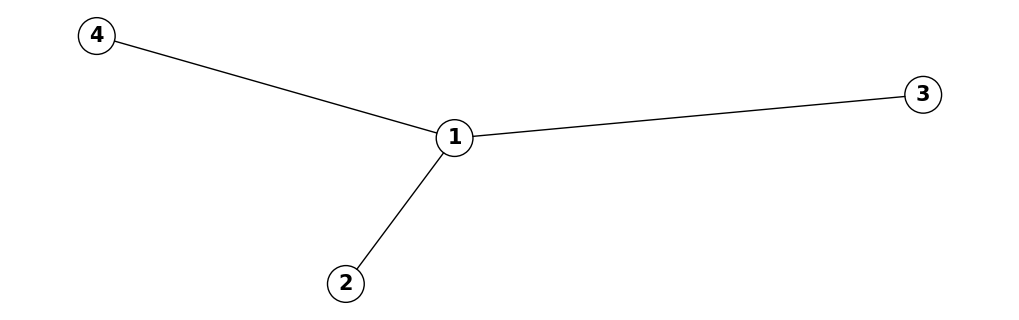

In [56]:
# Компиляция prufer.cpp с помощью g++
#subprocess.run(["g++", "-std=c++17", "-O3", "-march=native", "-o", "a", "prufer.cpp"], check=True)
# Запуск a.exe и ожидание завершения
subprocess.run(["a.exe", "4", "0"], check=True)

# Загружаем граф из файла в формате dot с помощью networkx и pydot
G = nx.nx_pydot.read_dot('graph.dot')

# Рисуем дерево
plt.figure(figsize=(10, 3))
nx.draw(G, 
        with_labels=True, 
        node_size=700,
        node_color="none",
        edgecolors="black",
        font_size=15, 
        font_weight='bold', 
        edge_color='black', 
        font_color='black') 
plt.show()

**Построение гистограммы**

In [3]:
# Функция для чтения рёбер из файла DOT
def read_dot_edges(dot_file):
    edges = []
    with open(dot_file, 'r') as f:
        for line in f:
            if '--' in line:
                parts = line.strip().strip(';').split(' -- ')
                if len(parts) == 2:
                    edges.append(tuple(map(int, parts)))
    return edges

# Функция сбора статистики
def get_sample_4deg(n, trials, density):
    all_degrees = []
    for i in range(trials):
        # Запускаем генерацию графа
        subprocess.run(["a.exe", str(n), str(density)], check=True)
        # Читаем рёбра из файла
        edges = read_dot_edges('graph.dot')
        # Подсчитываем степени вершин
        degree_count = defaultdict(int)  # Сброс перед каждым испытанием
        for u, v in edges:
            degree_count[u] += 1
            degree_count[v] += 1
        # Добавляем степени всех вершин в общий список
        all_degrees.extend(degree_count.values())
    return all_degrees

Использование генератора

In [ ]:
# Количество вершин
n = 100
# Плотность
density = 0.1
# Количество испытаний
trials = 10000
# Список для хранения степеней всех вершин во всех испытаниях
all_degrees = get_sample_4deg(n, trials, density)

# Определяем диапазон значений степеней вершин
min_degree = min(all_degrees)
max_degree = max(all_degrees)

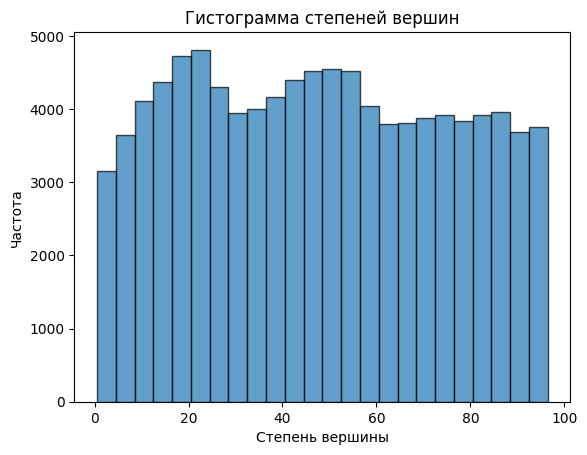

Частоты по бинам: [3158 3643 4108 4376 4723 4812 4303 3942 3995 4162 4394 4524 4544 4519
 4037 3802 3808 3880 3915 3838 3919 3961 3689 3761]
Границы бинов: [ 0.5  4.5  8.5 12.5 16.5 20.5 24.5 28.5 32.5 36.5 40.5 44.5 48.5 52.5
 56.5 60.5 64.5 68.5 72.5 76.5 80.5 84.5 88.5 92.5 96.5]


In [65]:
# Число бинов
num_bins = (n - 1)//4  # Бины от 1 до N-1, то есть, для 4 вершин, бины от 1 до 3
# Определяем границы бинов
bin_edges = np.arange(0.5, n + 0.5, n/(num_bins + 1))

# Строим гистограмму степеней вершин с использованием указанных границ бинов
plt.hist(all_degrees, bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')

# Показать гистограмму
plt.show()

'''
# Используем логарифмическую оценку для количества бинов
num_bins = n#math.ceil(math.log2(len(all_degrees)) + 1)

# Строим гистограмму степеней вершин
plt.hist(all_degrees, bins=num_bins, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')
plt.show()
'''
hist_values, bin_edges = np.histogram(all_degrees, bins=bin_edges)

# Выводим частоты для каждого бина
print("Частоты по бинам:", hist_values)
print("Границы бинов:", bin_edges)

Анализ гистограммы с ипользованием построения в c++

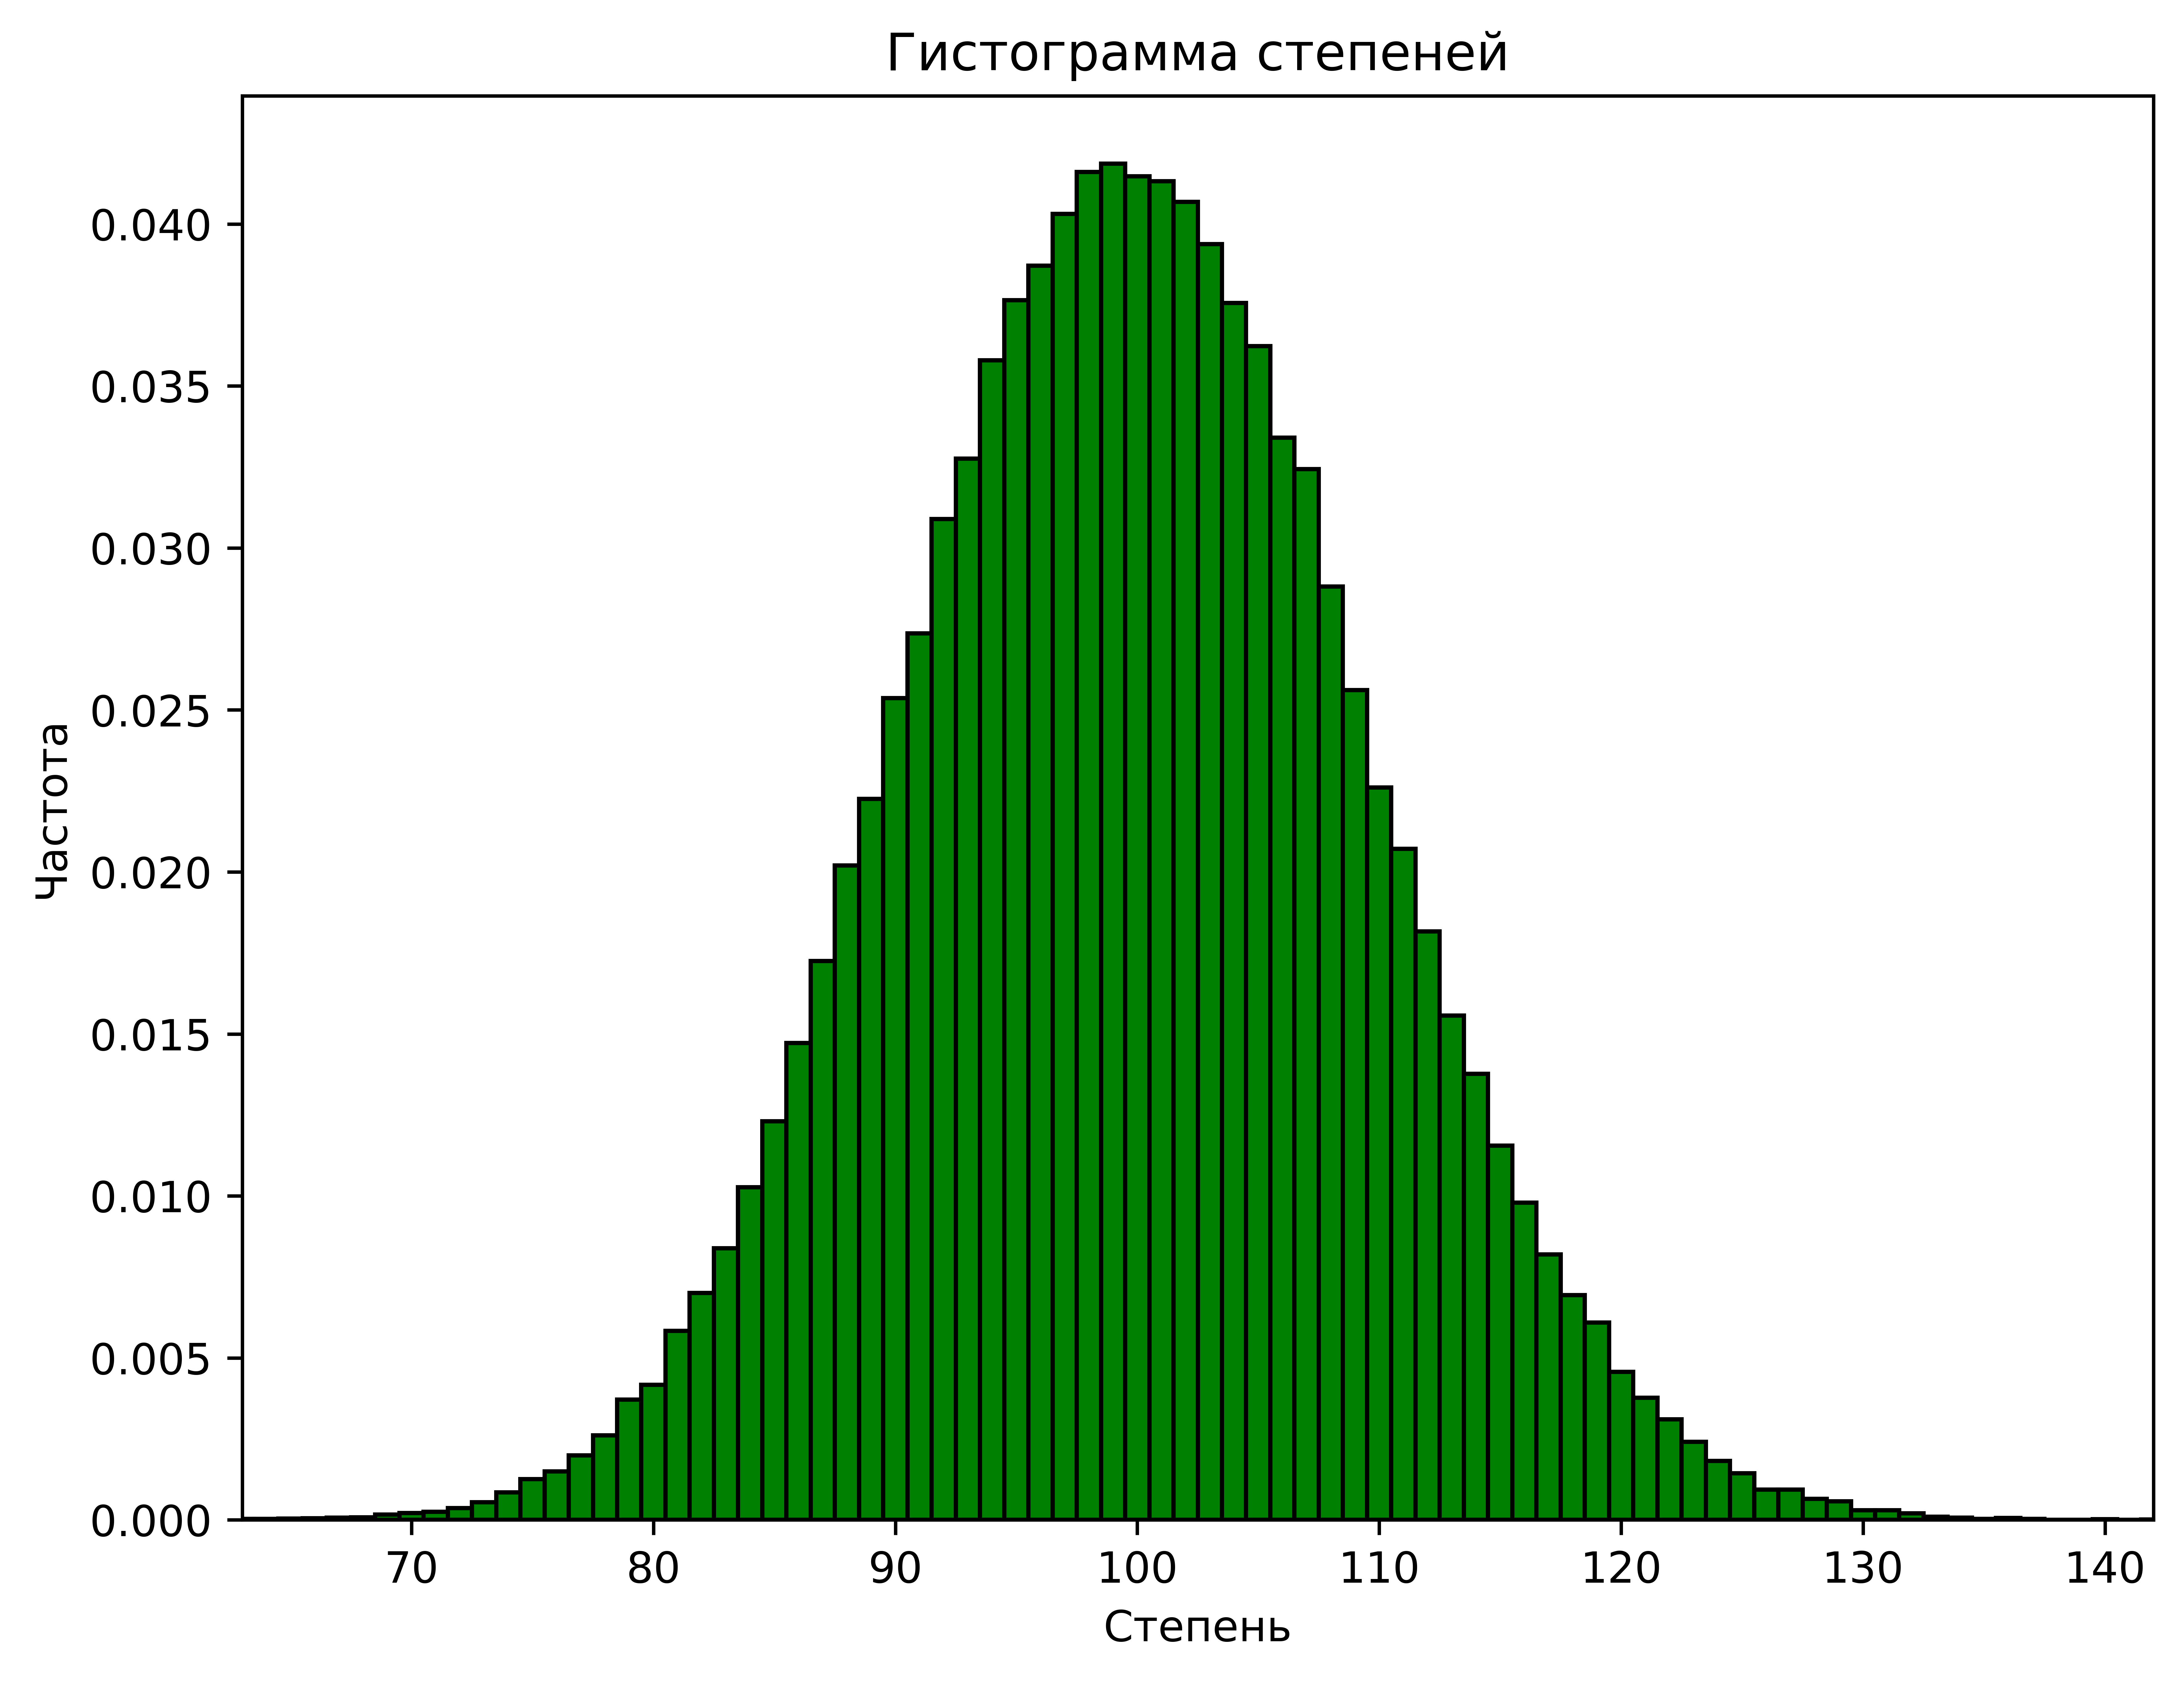

In [821]:
import numpy as np

def read_vector_from_file(filename):
    with open(filename, 'rb') as file:
        # Читаем размер вектора
        size = np.fromfile(file, dtype=np.uint64, count=1)[0]

        # Читаем данные вектора
        vec = np.fromfile(file, dtype=np.int32, count=size)

    return vec

# Чтение вектора из файла
deg = read_vector_from_file('histogram.bin')[1:] # степени 0 быть не может, т.к. граф связен по построению
#deg = deg[60:]
deg = deg[1:-2]
# Выводим содержимое вектора
# print(deg)

degrees = np.arange(len(deg))

plt.figure(figsize=(8, 6), dpi=1000)  # 8x6 дюймов и 100 DPI

# Определяем границы по ненулевым значениям
nonzero_indices = np.nonzero(deg)[0]
xmin, xmax = nonzero_indices[0], nonzero_indices[-1]
# Построение гистограммы
plt.bar(degrees, deg/sum(deg), width=1.0, align='center', color='green', edgecolor='black')
plt.xlim([xmin, xmax])
# Настройка подписей и заголовка
plt.xlabel('Степень')
plt.ylabel('Частота')
plt.title('Гистограмма степеней')
# Отображение графика
plt.show()

**Проверка гипотезы о нормальности**

In [864]:
def norm_xi2(degrees, deg, labtext = 'Степень', isBar = False):
    # Индексы степеней (x-координаты)
    degrees = np.arange(len(deg))

    # Находим среднее и стандартное отклонение по данным (с учетом частот)
    mean = np.average(degrees, weights=deg)
    std_dev = np.sqrt(np.average((degrees - mean) ** 2, weights=deg))

    # Вычисление ожидаемых частот
    total_count = np.sum(deg)  # Общее количество данных
    expected_freq = total_count * norm.pdf(degrees, mean, std_dev)  # Переводим PDF в частоты

    # Коррекция малых значений, чтобы избежать деления на 0
    expected_freq[expected_freq < 1e-6] = 1e-6

    # Вычисление статистики хи-квадрат
    chi_statistic = np.sum((deg - expected_freq) ** 2 / expected_freq)

    # Число степеней свободы (уменьшаем, если объединяем редкие классы)
    dfree = len([i for i in deg if i > 0]) - 3  # len(degrees) - 3  # Отнимаем 1 за число параметров (μ, σ) и 1 за нормализацию

    # Критическое значение хи-квадрат
    alpha = 0.01
    chi_critical = chi2.ppf(1 - alpha, dfree)

    # Форматируем строку для легенды с статистикой и критическим значением
    chi_label = r"$\chi^2 = $" + f"{chi_statistic:.2f}, \n" + r"$\chi^2_{max} = $" + f"{chi_critical:.2f}"

    #chi_label = "$\xi^2$: {chi_statistic:.2f}, Критическое значение: {chi_critical:.2f}"

    # Вывод результатов
    print(f"Среднее: {mean:.2f}, СКО: {std_dev:.2f}")
    print(f"Статистика критерия хи-квадрат: {chi_statistic:.2f}")
    print(f"Критическое значение хи-квадрат при alpha={alpha}: {chi_critical:.2f}")

    # Проверка гипотезы
    if chi_statistic < chi_critical:
        print("Гипотеза о нормальности НЕ отвергается.")
    else:
        print("Гипотеза о нормальности отвергается.")

    # Построение графика
    plt.figure(figsize=(8, 6), dpi=1000)  # 8x6 дюймов и 100 DPI

    # Визуализация

    if isBar == False:
        plt.bar(degrees, deg, width=1.0, align='center', color='lightgreen', edgecolor='black', label="Наблюдаемые частоты")
        plt.plot(degrees, expected_freq, color='red', linestyle='dashed', linewidth=1, label="Ожидаемые частоты", alpha=1)
    else:
        plt.bar(degrees, deg, width=1.0, align='center', color='lightgreen', edgecolor='black', label="Наблюдаемые частоты", alpha = 0.5)
        plt.bar(degrees, expected_freq, width=0.6, align='center', color='red', edgecolor='black', label="Ожидаемые частоты", alpha=0.3)     

    # Добавляем легенду с дополнительной информацией
    plt.legend(title=chi_label)

    # Настройки отображения
    plt.xlim([degrees[deg > 0][0] - 0.5, degrees[deg > 0][-1] + 0.5])  # Корректируем границы оси X

    plt.xlabel(labtext)
    plt.ylabel('Частота')
    plt.title(r'Гистограмма частот vs sample $\,N$(' + f"{mean:.2f}, {std_dev:.2f}" r')')

    # Отображение графика
    plt.show()    

Среднее: 99.90, СКО: 9.48
Статистика критерия хи-квадрат: 160.06
Критическое значение хи-квадрат при alpha=0.01: 105.20
Гипотеза о нормальности отвергается.


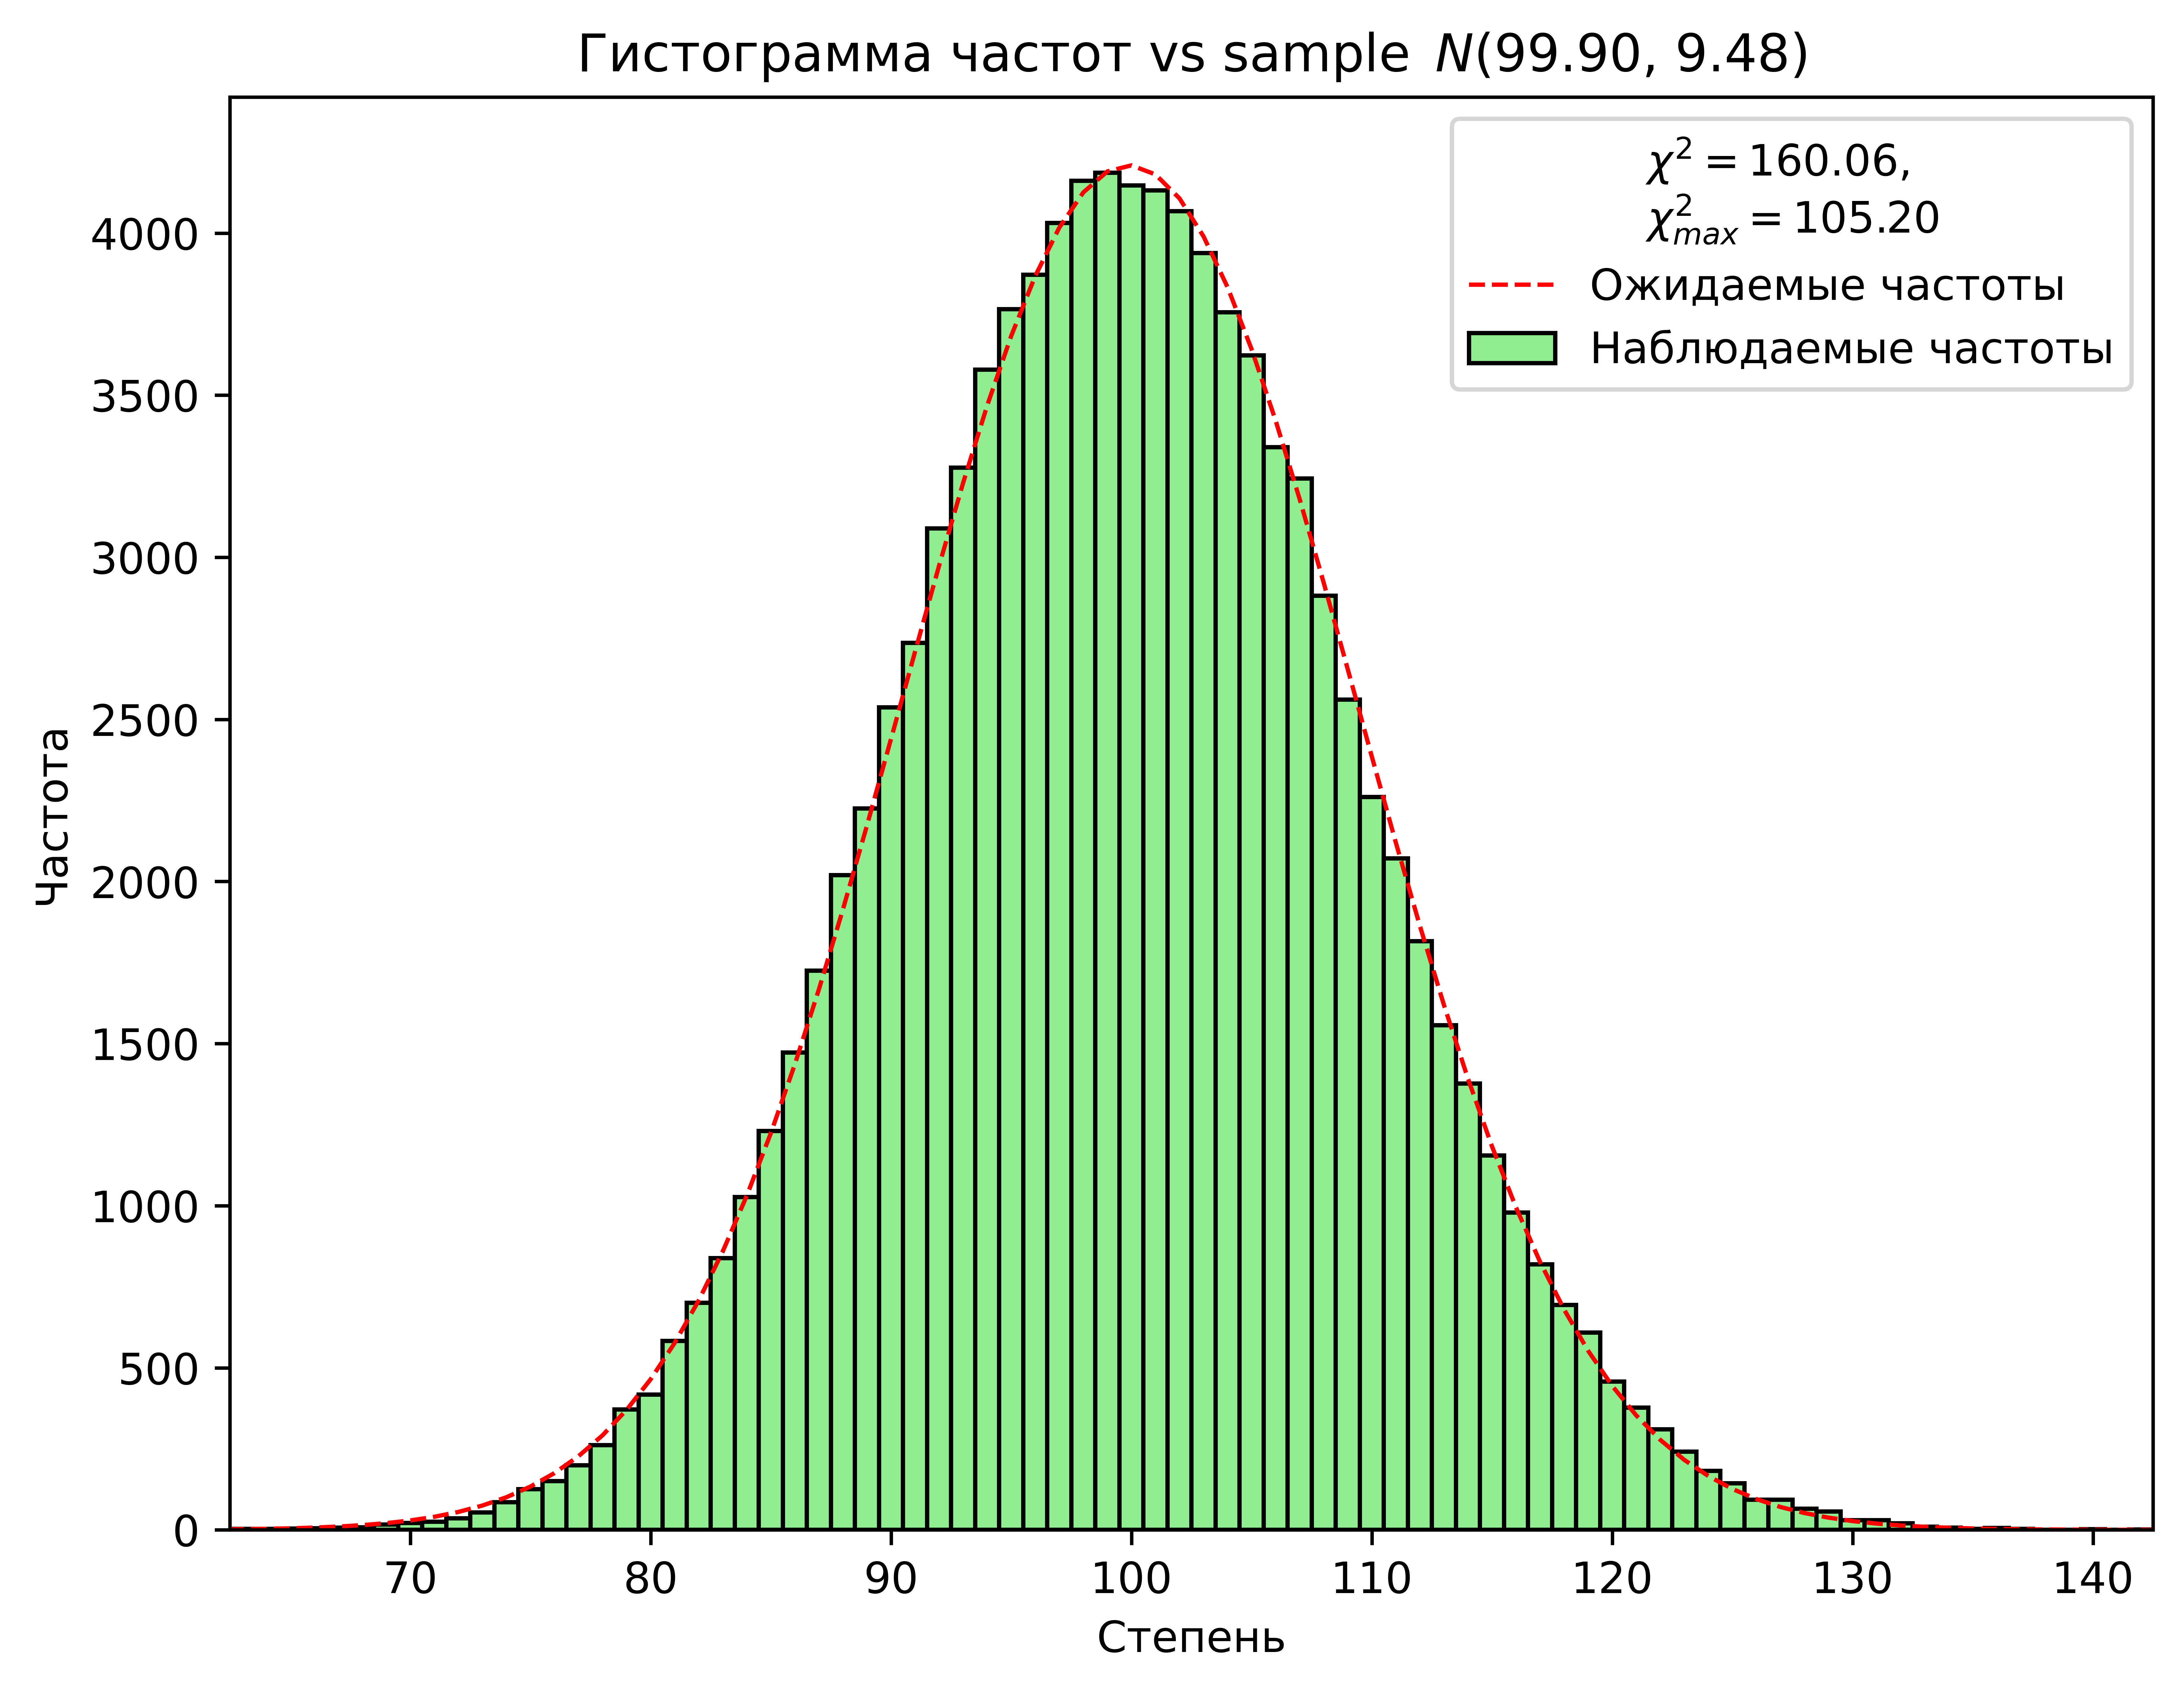

In [823]:
norm_xi2(degrees, deg)

In [865]:
# Функция для вычисления статистики хи-квадрат биномального распределения
def binomial_xi2(degrees, deg, labtext = 'Степень', isBar = False):
    degrees = np.arange(len(deg))
    # Оценка параметров биномиального распределения
    n = degrees.max()  # Максимальная степень как число испытаний
    p = np.sum(degrees * deg) / (n * np.sum(deg))  # Оценка вероятности успеха
    print("n =", n, "p =", p)
    # Вычисление ожидаемых частот по биномиальному распределению
    total_count = np.sum(deg)
    expected_freq = total_count * binom.pmf(degrees, n, p)

    # Коррекция малых значений, чтобы избежать деления на 0
    expected_freq[expected_freq < 1e-6] = 1e-6

    # Вычисление статистики хи-квадрат
    chi_statistic = np.sum((deg - expected_freq) ** 2 / expected_freq)

    # Число степеней свободы
    dfree = len([i for i in deg if i > 0]) - 2  # Отнимаем 1 за n и 1 за p

    # Критическое значение хи-квадрат при alpha=0.05
    alpha = 0.01
    chi_critical = chi2.ppf(1 - alpha, max(dfree, 1))

    chi_label = r"$\chi^2 = $" + f"{chi_statistic:.2f}, \n" + r"$\chi^2_{max} = $" + f"{chi_critical:.2f}"
    # Вывод результатов
    mean_binom = n * p
    std_dev_binom = np.sqrt(n * p * (1 - p))

    # Определяем границы по ненулевым значениям
    nonzero_indices = np.nonzero(deg)[0]
    xmin, xmax = nonzero_indices[0] - 0.5, nonzero_indices[-1] + 0.5

    plt.figure(figsize=(8, 6), dpi=1000)  # 8x6 дюймов и 100 DPI
    # Визуализация результатов биномиального распределения

    if isBar == False:
        plt.bar(degrees, deg/sum(deg), width=1.0, align='center', color='lightgreen', edgecolor='black', label="Наблюдаемые частоты", alpha = 0.7)
        plt.plot(degrees, expected_freq/sum(expected_freq), color='red', linestyle='dashed', linewidth=1, label="Ожидаемые частоты", alpha = 1)
    else:
        plt.bar(degrees, deg/sum(deg), width=1.0, align='center', color='lightgreen', edgecolor='black', label="Наблюдаемые частоты", alpha = 0.7)
        plt.bar(degrees, expected_freq/sum(expected_freq), width=0.6, align='center', color='red', edgecolor='black', label="Ожидаемые частоты", alpha = 0.3)        


    plt.legend(title=chi_label)


    plt.xlabel('Степень')
    plt.ylabel('Частота')
    plt.title(r'Гистограмма частот vs sample $\,Bin$(' + f"{p:.2f}, {n:.0f}" r')')
    plt.xlim([xmin, xmax])  # Устанавливаем границы оси X
    #print([xmin, xmax])

    # Вывод легенды под график
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
    plt.show()

    # Вывод результатов
    print(f"Среднее: {mean_binom:.2f}, СКО: {std_dev_binom:.2f}")
    print(f"Статистика критерия хи-квадрат: {chi_statistic:.2f}")
    print(f"Критическое значение хи-квадрат при на уровне значимости 1 - alpha = {1 - alpha}: {chi_critical:.2f}")

    # Проверка гипотезы
    if chi_statistic < chi_critical:
        print("Гипотеза о биномиальном распределении НЕ отвергается.")
    else:
        print("Гипотеза о биномиальном распределении отвергается.")
    

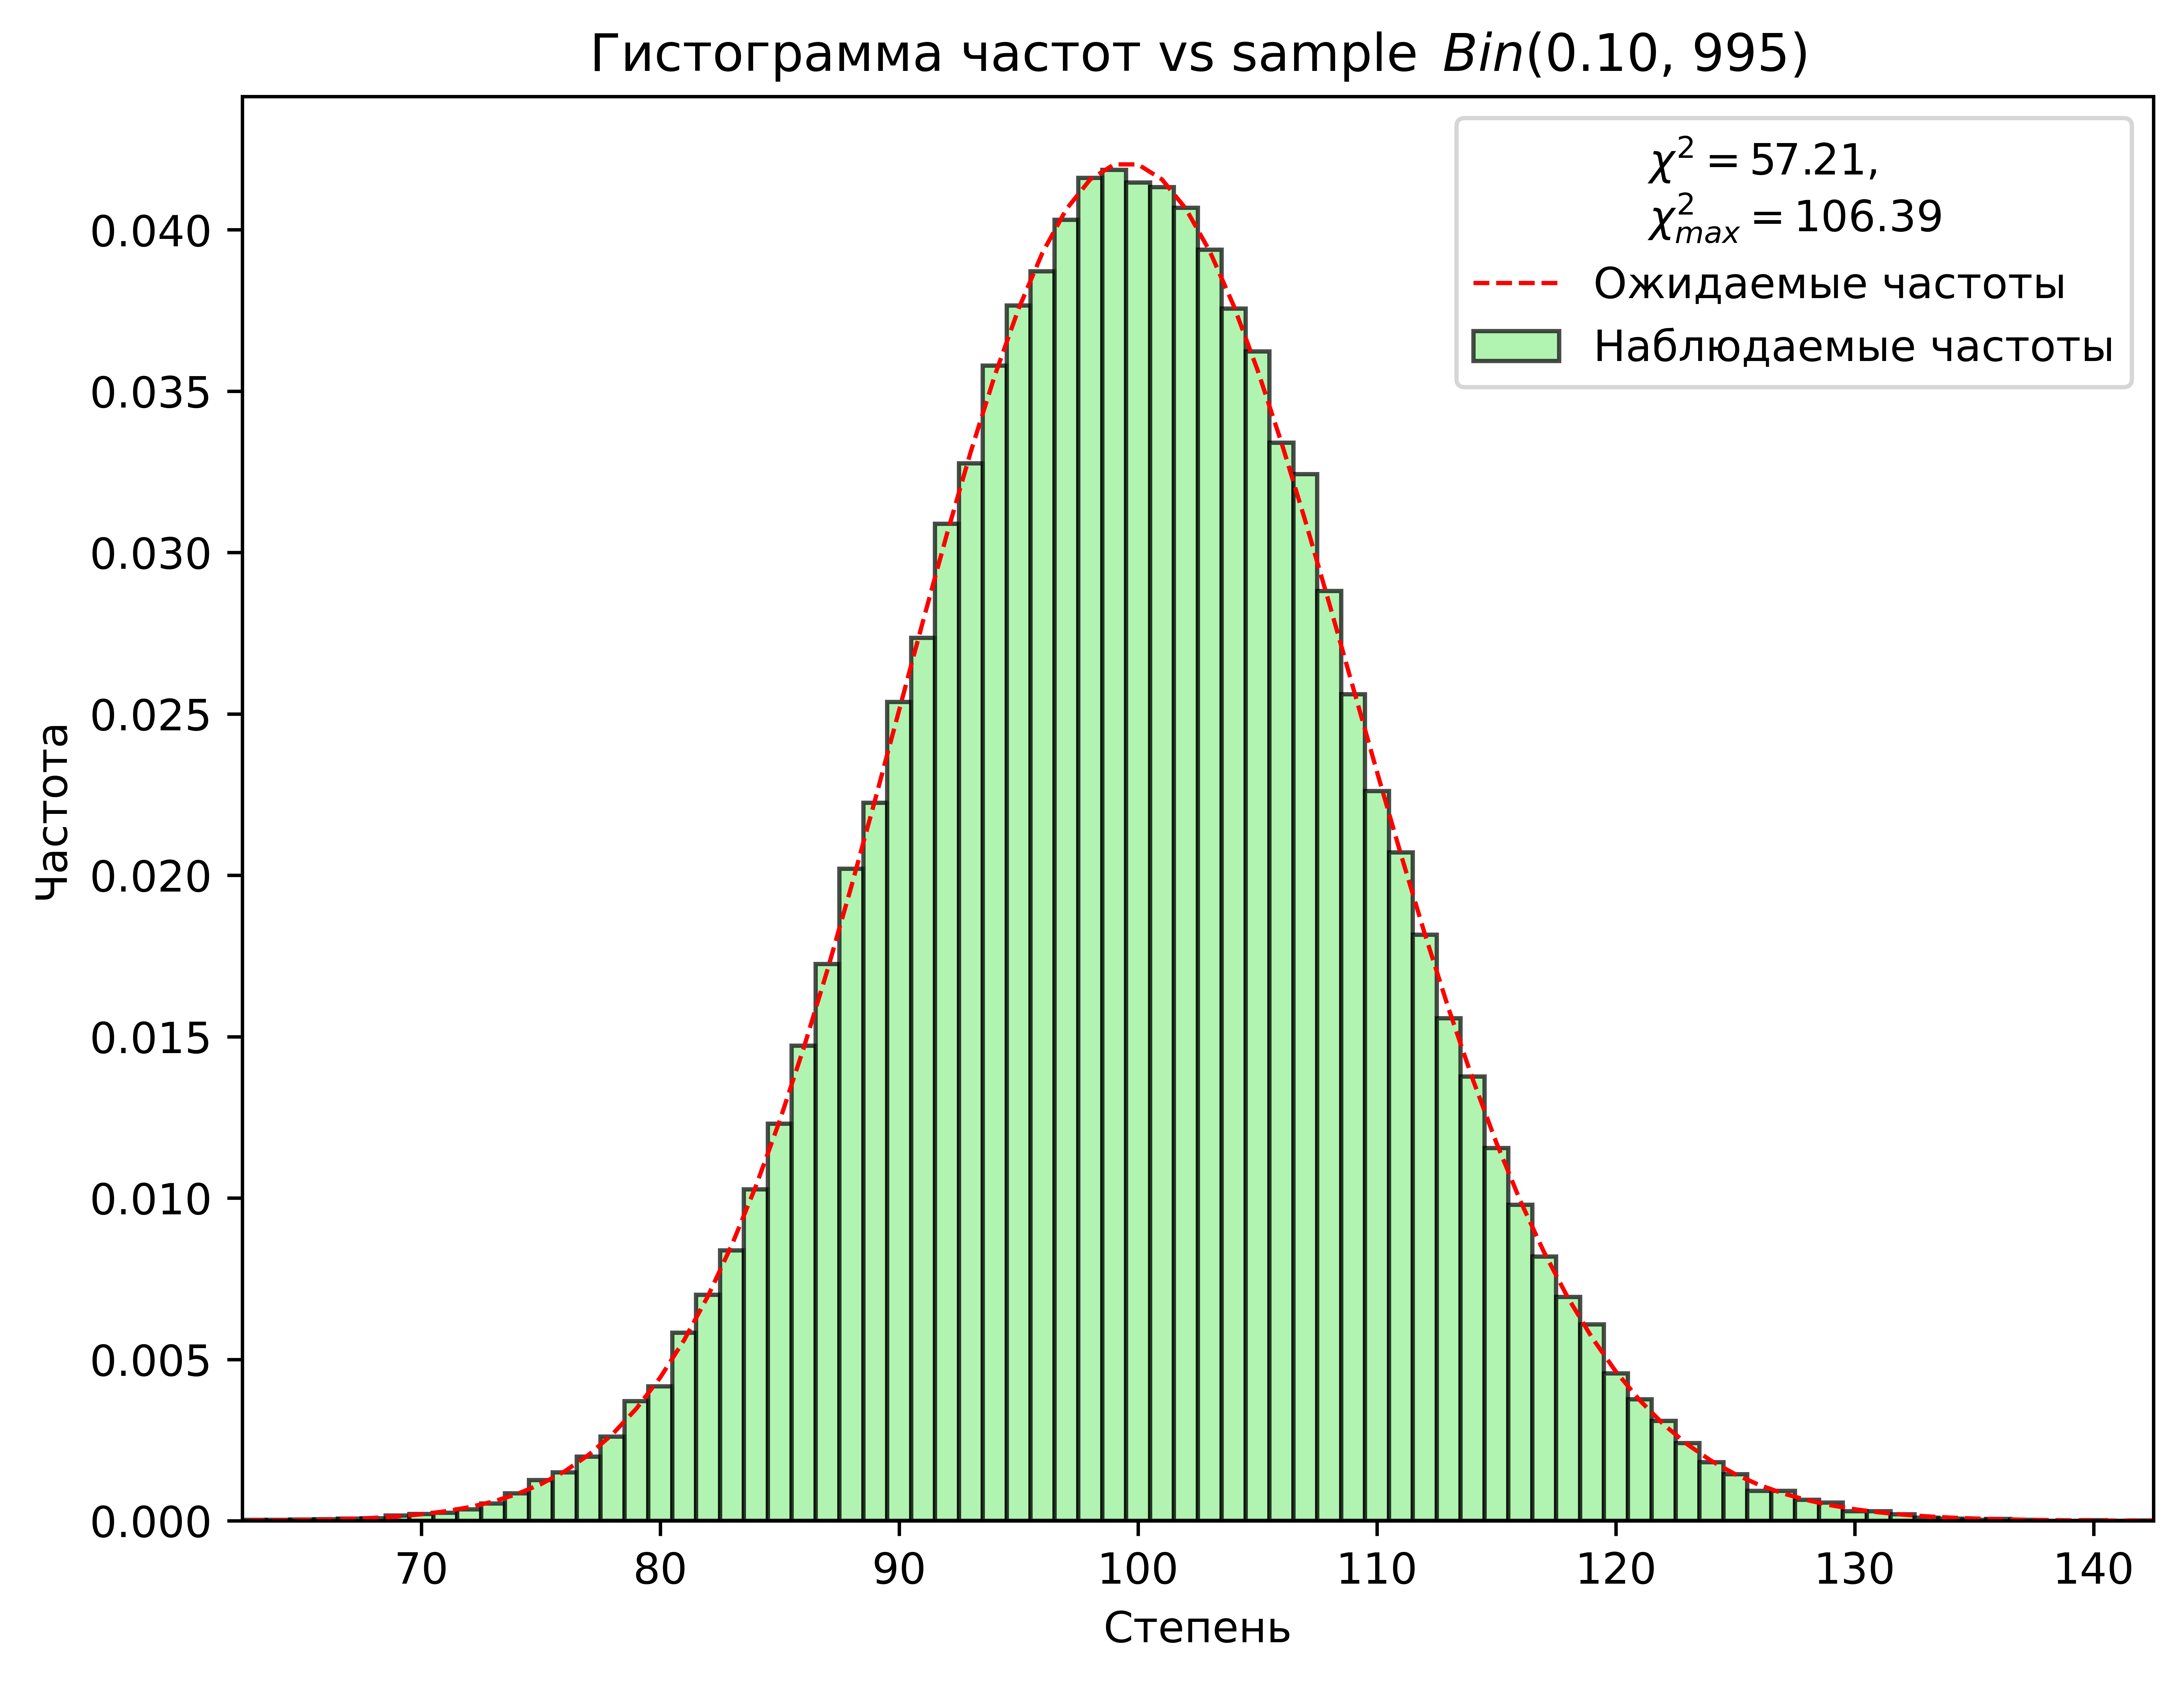

Среднее: 99.90, СКО: 9.48
Статистика критерия хи-квадрат: 57.21
Критическое значение хи-квадрат при на уровне значимости 1 - alpha = 0.99: 106.39
Гипотеза о биномиальном распределении НЕ отвергается.


In [825]:
binomial_xi2(degrees, deg)

# Анализ результатов Монте Карло

In [854]:
p = "10000"     # колчиество вершин
g = "10"        # количество графов
s = "1000"      # количество поисков в графе
di = "[0.0001]" # плотности
subprocess.run(["main.exe", p, g, s, di], check=True)

CompletedProcess(args=['main.exe', '10000', '10', '1000', '[0.0001]'], returncode=0)

In [859]:

# Чтение файла логов в датафрейм
df = pd.read_csv('logger/log.txt', sep='\s+', header=None, names=['p', 'Density', 'Distance', 'BFS_Result', 'DFS_Result'])

# Вычисление средних значений по плотности
averages_by_density = df.groupby('Density').agg({'BFS_Result': 'mean', 'DFS_Result': 'mean', 'Distance': 'mean', 'p': 'first'}).reset_index()
averages_by_density.rename(columns={'BFS_Result': 'BFS Avg', 'DFS_Result': 'DFS Avg', 'Distance': 'Distance Avg'}, inplace=True)

# Вычисление средних значений по (плотность, расстояние) с количеством пар
averages_by_density_distance = df.groupby(['Density', 'Distance']).agg({'BFS_Result': ['mean', 'count'], 'DFS_Result': 'mean', 'p': 'first'}).reset_index()
averages_by_density_distance.columns = ['Density', 'Distance', 'BFS Avg', 'Count', 'DFS Avg', 'p']
averages_by_density_distance['BFS/DFS'] = averages_by_density_distance['BFS Avg'] / averages_by_density_distance['DFS Avg']
averages_by_density_distance = averages_by_density_distance.dropna(subset=['BFS/DFS'])
averages_by_density = averages_by_density[['Density', 'p', 'BFS Avg', 'DFS Avg', 'Distance Avg']]
averages_by_density_distance = averages_by_density_distance[['Density', 'p', 'Distance', 'BFS Avg', 'DFS Avg', 'Count', 'BFS/DFS']]

print("Средние значения по плотности:")
print(averages_by_density)
final_df = averages_by_density_distance.copy()
final_df = final_df.sort_values(by=['p', 'Density'])
final_df.set_index('Density', inplace=True)
final_df

Средние значения по плотности:
   Density     p     BFS Avg     DFS Avg  Distance Avg
0   0.0005  1000  504.334100  500.632700     10.762700
1   0.0010  1000  498.814900  501.989600     10.988400
2   0.0050  1000  497.541000  502.609200      4.452800
3   0.0100  1000  502.694400  501.883500      3.262400
4   0.1000  1000  501.485900  504.116200      1.900000
5   0.2000  1000  503.845278  495.190183      1.801605


,p,Distance,BFS Avg,DFS Avg,Count,BFS/DFS
Density,,,,,,
0.0005,1000,1,3.181818,489.909091,22,0.006495
0.0005,1000,2,7.758621,795.344828,29,0.009755
0.0005,1000,3,18.696970,836.969697,66,0.022339
0.0005,1000,4,44.686131,791.014599,137,0.056492
0.0005,1000,5,79.531496,794.086614,254,0.100155
...,...,...,...,...,...,...
0.0100,1000,5,985.476190,361.547619,42,2.725716
0.1000,1000,1,52.130000,939.071000,1000,0.055512
0.1000,1000,2,551.414333,455.787889,9000,1.209805


Проанализируем распределение расстояний

C:\Users\skiva\AppData\Local\Temp\ipykernel_23836\1858020851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Distance'] = filtered_data['Distance'].round().astype(int)


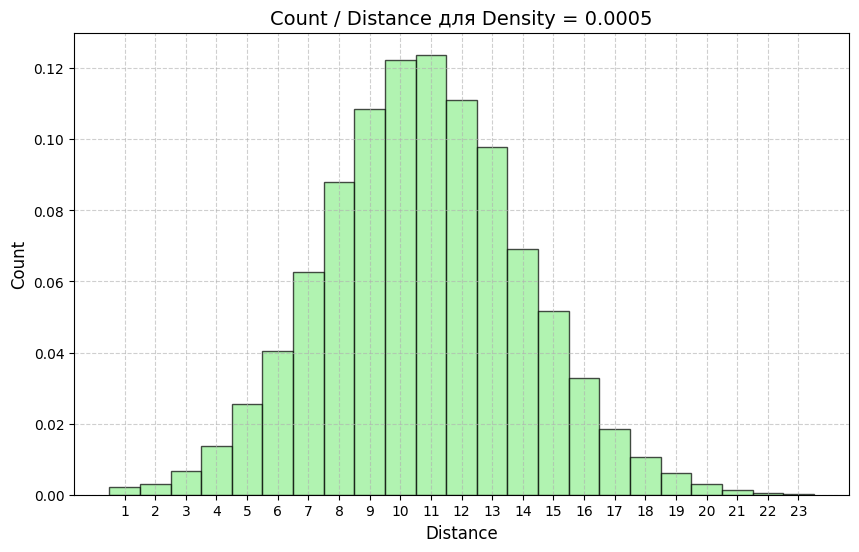

In [860]:
# Задаем плотность, для которой нужно построить гистограмму
target_density = 0.0005
filtered_data = averages_by_density_distance[averages_by_density_distance['Density'] == target_density]
filtered_data['Distance'] = filtered_data['Distance'].round().astype(int)

grouped_data = filtered_data.groupby('Distance')['Count'].sum()

plt.figure(figsize=(10, 6))
plt.bar(grouped_data.index, grouped_data.values / sum(grouped_data.values), width=1.0, align='center', color='lightgreen', edgecolor='black', label="Наблюдаемые частоты", alpha=0.7)

plt.xlabel('Distance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Count / Distance для Density = {target_density}', fontsize=14)

plt.xticks(grouped_data.index)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

n = 22 p = 0.44375909090909094


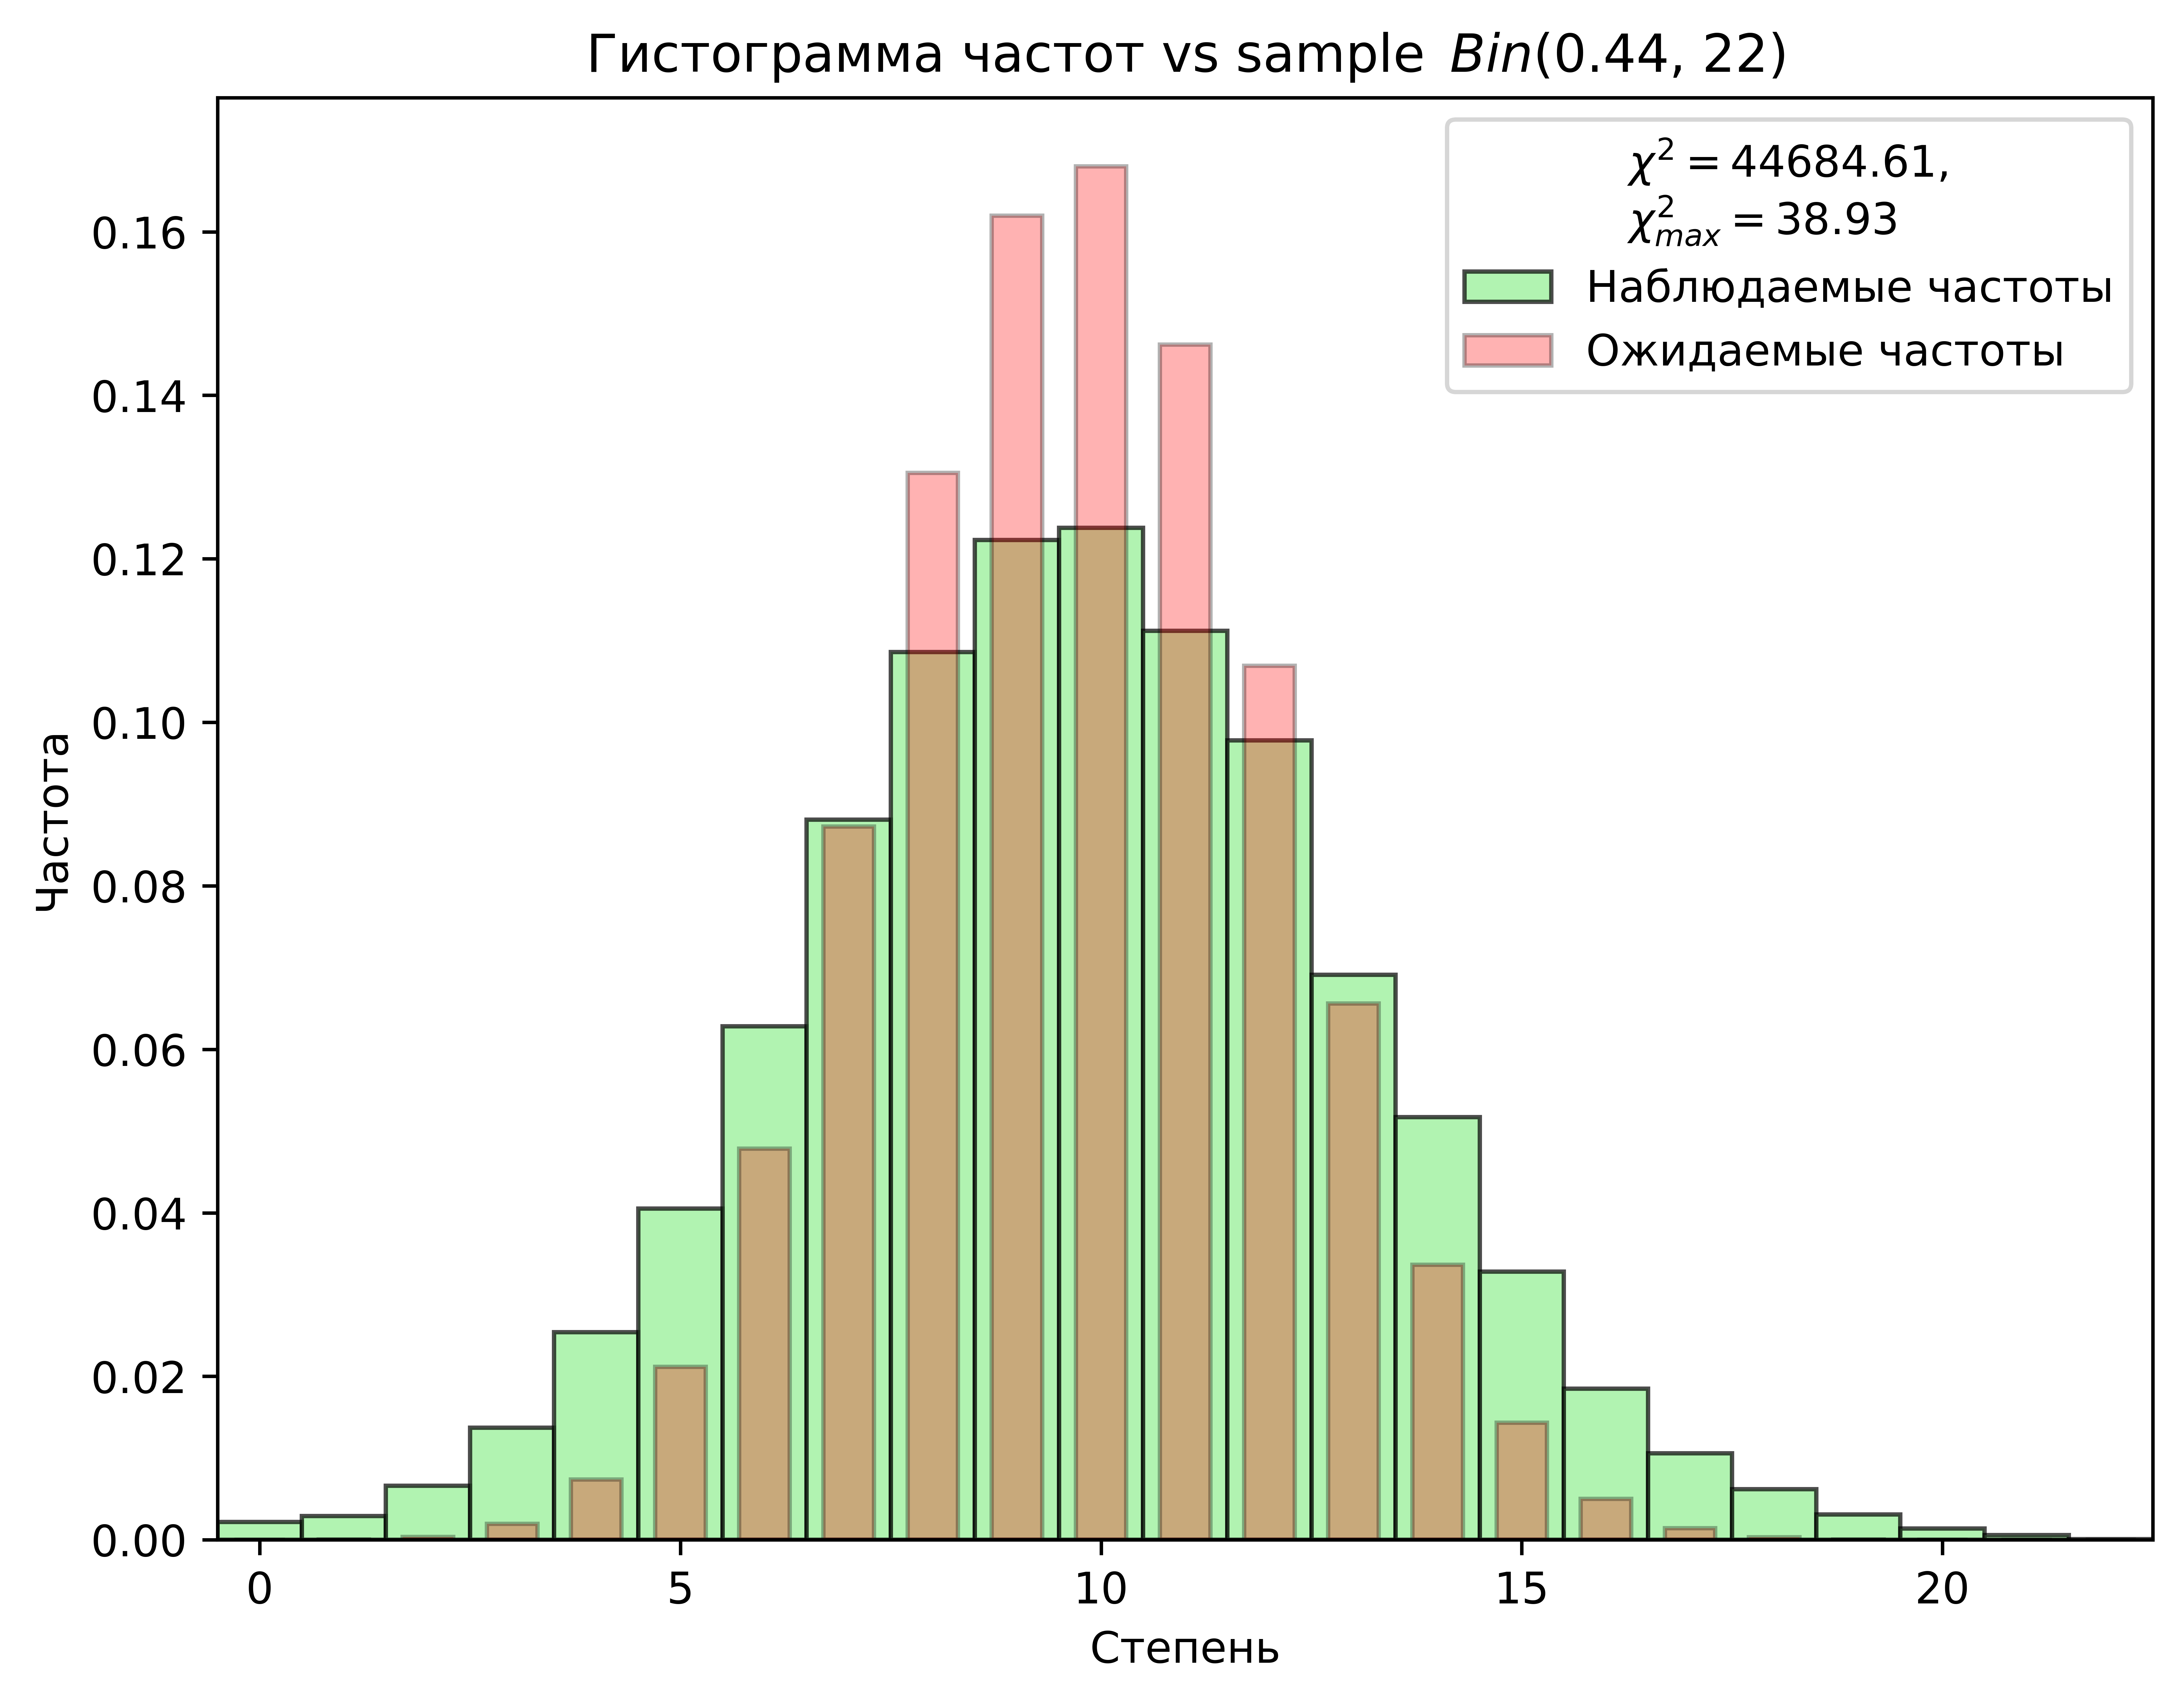

Среднее: 9.76, СКО: 2.33
Статистика критерия хи-квадрат: 44684.61
Критическое значение хи-квадрат при на уровне значимости 1 - alpha = 0.99: 38.93
Гипотеза о биномиальном распределении отвергается.
Среднее: 9.76, СКО: 3.26
Статистика критерия хи-квадрат: 27.50
Критическое значение хи-квадрат при alpha=0.01: 37.57
Гипотеза о нормальности НЕ отвергается.


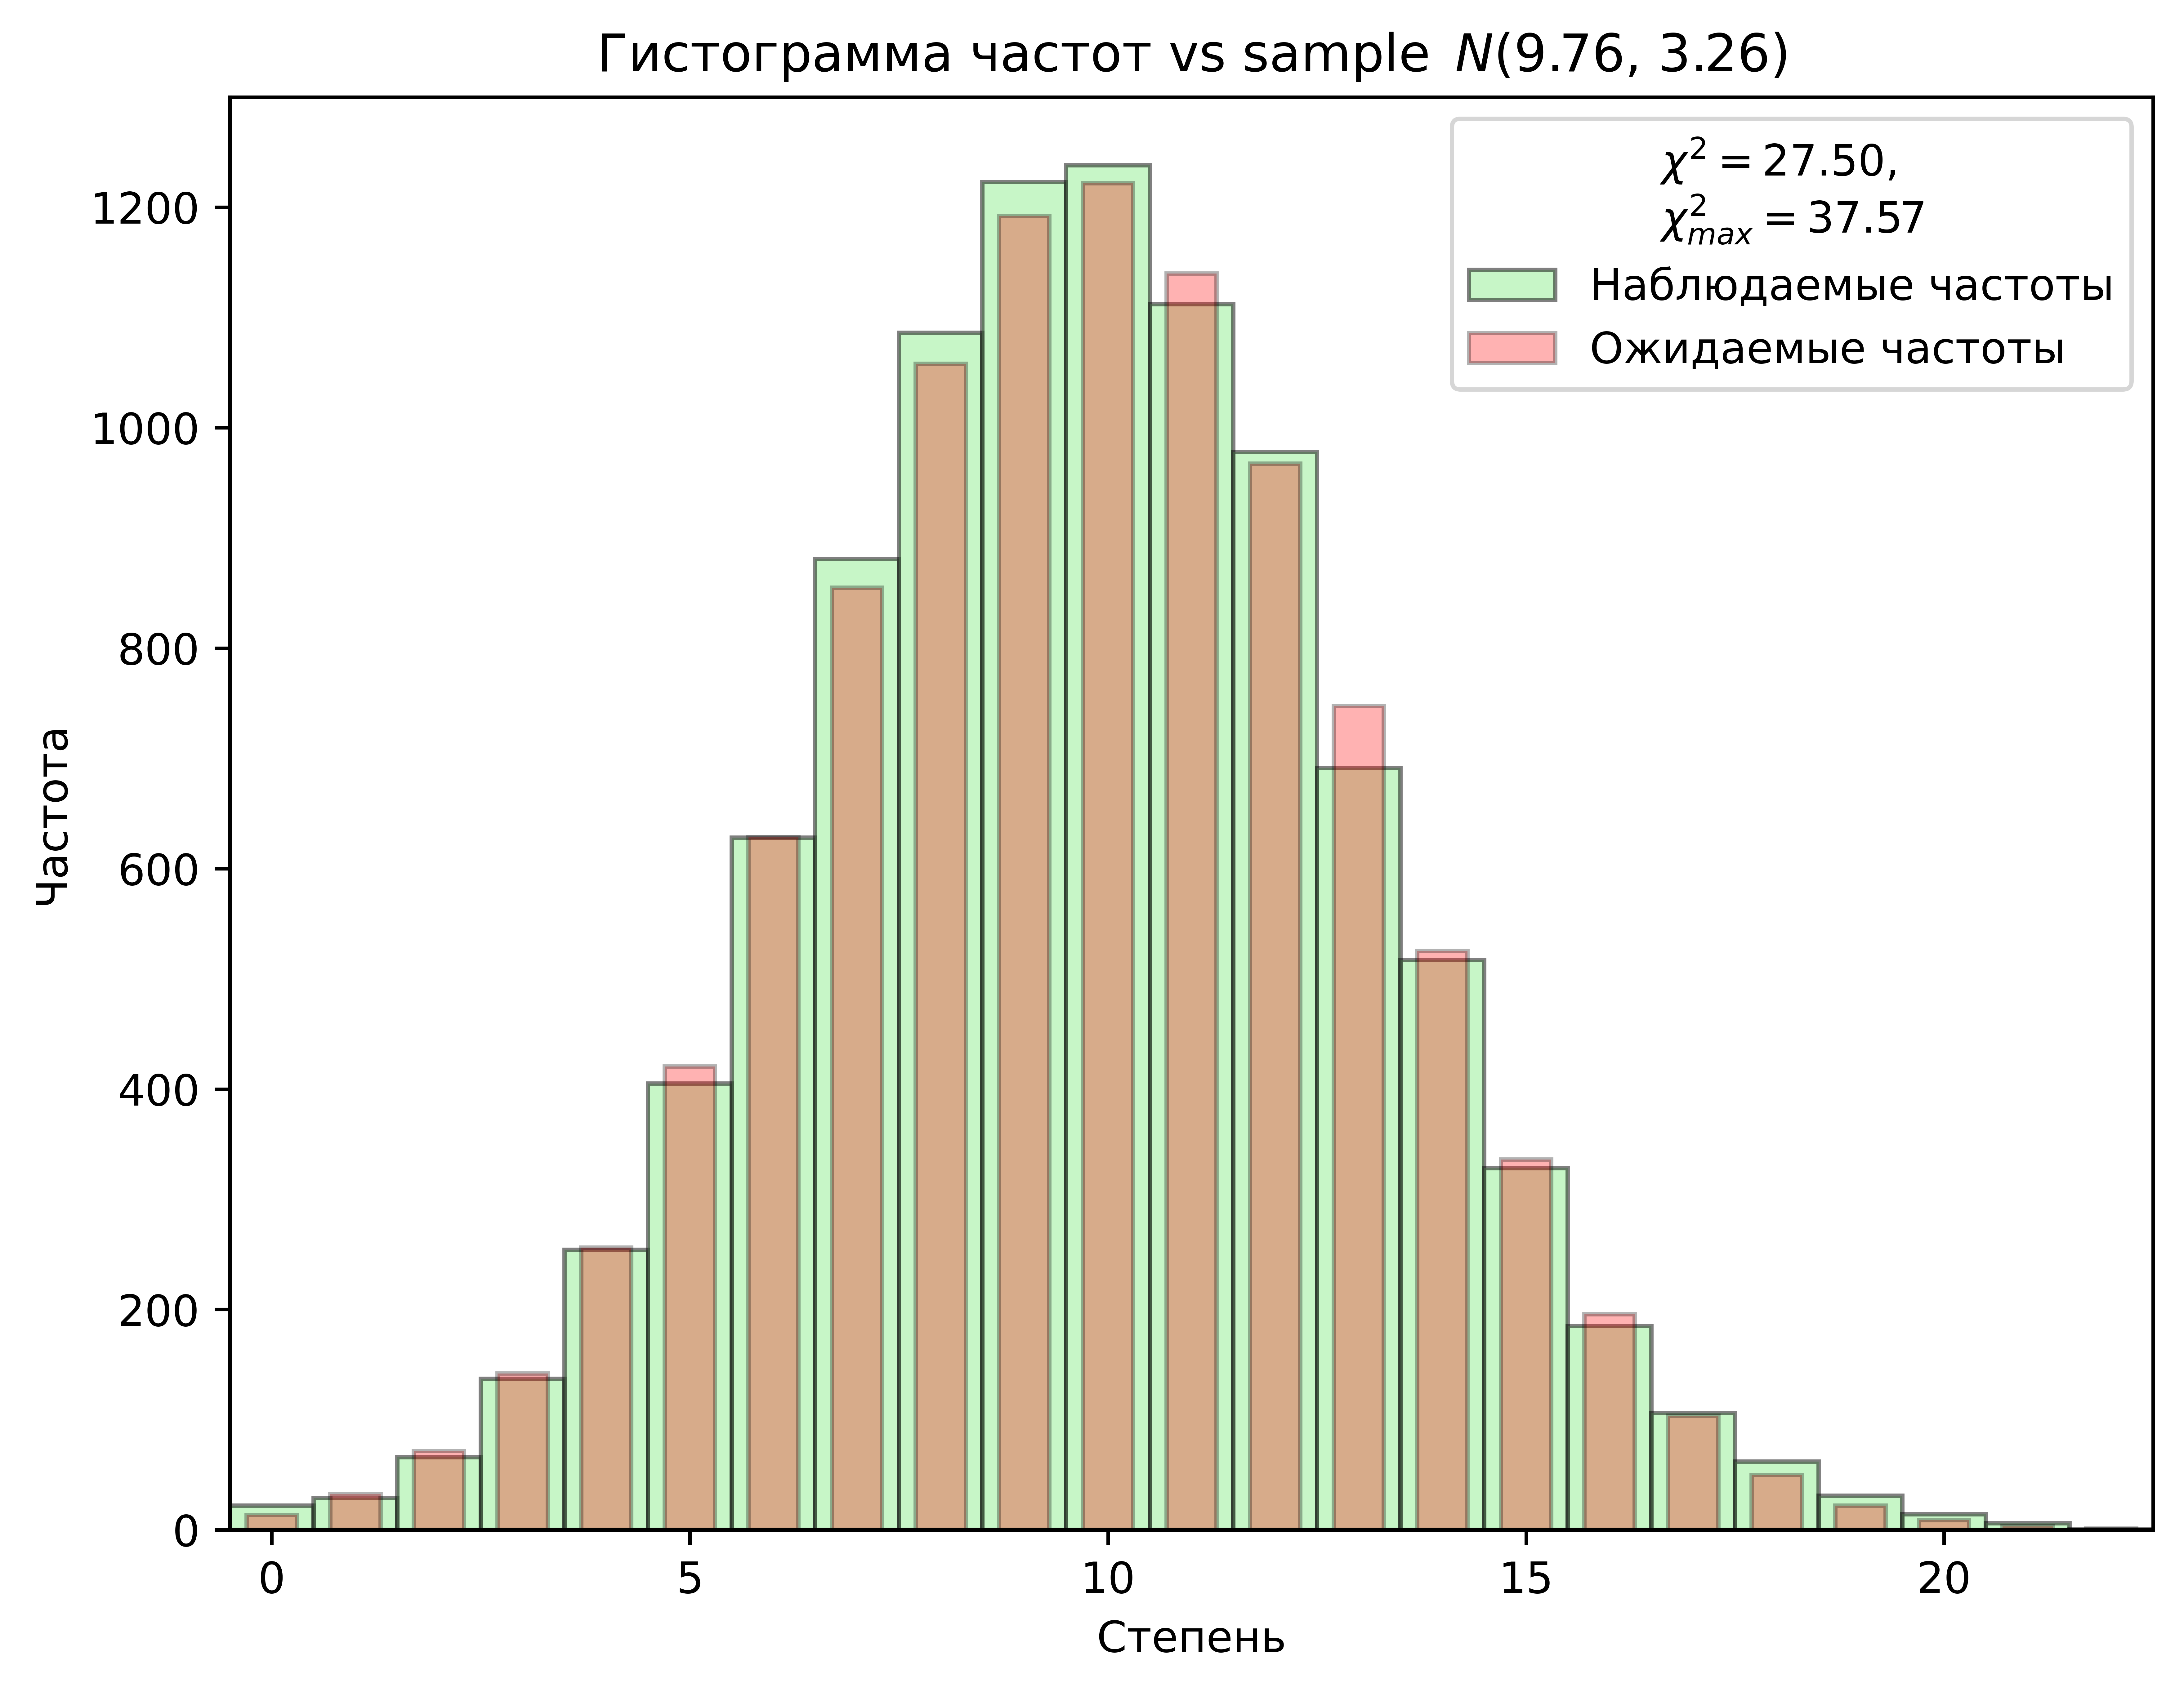

In [863]:
degrees = grouped_data.index
deg = grouped_data.values
binomial_xi2(degrees, deg, True)
norm_xi2(degrees, deg, True)